In [52]:
import numpy  as np
import matplotlib.pyplot as plt
import cv2
import statsmodels.api as sm
import scipy

In [ ]:
from sklearn.linear_model import LinearRegression

In [53]:
num_train_images = 100
num_test_images = 10

In [54]:
np.random.seed(0)

In [55]:
# parameters
n = (100,100) # size of grid
R = 40    # degree of continuity
 
## code
xx,yy = np.meshgrid(np.arange(0,n[0],1)-n[0]//2,np.arange(0,n[1],1)-n[1]//2)
C = np.exp(-3*np.sqrt(xx*xx+yy*yy)/R)
fftC = np.fft.fft2(C)

dataset = np.empty((0,100,100))
for i in range(num_train_images):
    fftN = np.fft.fft2(np.random.normal(size=n))
    sample = np.real(np.fft.ifft2(np.sqrt(np.abs(fftC))*fftN))
    dataset = np.concatenate((dataset, np.expand_dims(sample, axis=0)), axis=0)
 
dataset = (dataset-np.min(dataset))/(np.max(dataset)-np.min(dataset))
 
# plotting
#plt.imshow(sample)
#plt.colorbar()


In [57]:
test_dataset = np.empty((0,100,100))
for i in range(num_test_images):
    fftN = np.fft.fft2(np.random.normal(size=n))
    sample = np.real(np.fft.ifft2(np.sqrt(np.abs(fftC))*fftN))
    test_dataset = np.concatenate((test_dataset, np.expand_dims(sample, axis=0)), axis=0)
test_dataset = (test_dataset-np.min(test_dataset))/(np.max(test_dataset)-np.min(test_dataset))

In [206]:
def blur_image(dataset, kernel_size):
    im_shape = dataset.shape[1:]
    blur_kernel = np.ones(kernel_size)/(kernel_size[0]*kernel_size[1])
    blurred_dataset = np.empty((0,dataset.shape[1],dataset.shape[2]))
    for i in range(dataset.shape[0]):
        blurred_im = scipy.signal.correlate2d(dataset[i], blur_kernel, mode='same', boundary='fill', fillvalue=0) + (np.random.random((100,100))-0.5)/20
        blurred_dataset = np.concatenate((blurred_dataset, np.expand_dims(blurred_im, axis=0)), axis=0)

    return blurred_dataset

In [207]:
blurred_images = blur_image(dataset, (5,5))


In [208]:
blurred_images_test =  blur_image(test_dataset, (5,5))

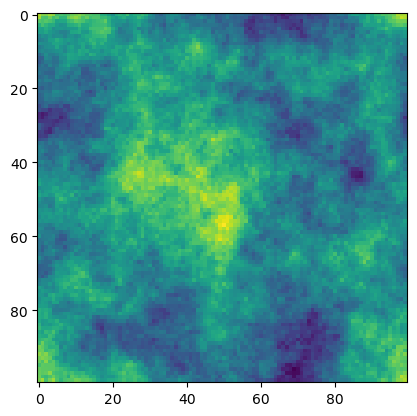

In [67]:
plt.imshow(dataset[0])

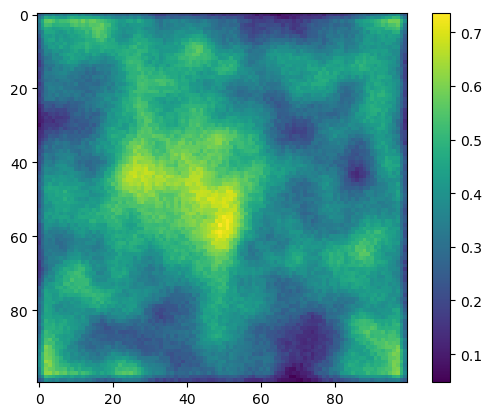

In [209]:
plt.imshow(blurred_images[0])
plt.colorbar()

In [210]:
def create_nbh_and_blur(ims, blurred_ims, nbh_size,blur_size):
    m, n = nbh_size
    h, w = blur_size
    h = h//2
    w = w//2
    train_dat = []
    blur_dat = []
    #train_dat = np.empty((70,0))
    for im, bl_im in zip(ims,blurred_ims):
        #print(im.shape)
        for i in range(m, ims.shape[1]-m):
                for j in range(n, ims.shape[1]-n):
                    
                    neighborhood = im[i+1-m:i+1,j-n:(j+n+1)]
                    flat_n = neighborhood.flatten()
                    blur_nbh = bl_im[i-h:i+h+1, j-w:j+w+1]
                    blur_nbh_flat = blur_nbh.flatten()[:]
                    dlt = n
                    
                    nbh_ij = flat_n[:-(dlt)]
                    #nbh_and_blur = np.concatenate((nbh_ij,blur_nbh_flat),axis = 0)
                    #print(nbh_and_blur.shape)
                    #train_dat.append(np.reshape(nbh_and_blur,(-1,1)))
                    train_dat.append(nbh_ij)
                    blur_dat.append(blur_nbh_flat)
                    #nbh_and_blur =  np.reshape(nbh_and_blur,(-1,1))
                    #print(nbh_and_blur.shape)
                    #train_dat = np.concatenate((train_dat, nbh_and_blur),axis=1)
    train_dat = np.array(train_dat)
    blur_dat = np.array(blur_dat)
    #nbh_and_blur = np.concatenate((train_dat,blur_dat),axis=1)
    nbh_and_blur = np.concatenate((blur_dat, train_dat),axis=1)
    return np.array(np.concatenate((np.ones((nbh_and_blur.shape[0],1)),nbh_and_blur),axis=1))



In [211]:
neighborhood_data = create_nbh_and_blur(ims=dataset, blurred_ims = blurred_images, nbh_size=(5,5), blur_size=(5,5))
np.array(neighborhood_data).shape

(810000, 76)

In [212]:
X_T_X = neighborhood_data[:,:-1].T@neighborhood_data[:,:-1]

In [213]:
eigval =np.linalg.eigvals(X_T_X)

In [214]:
vals, eigvec =np.linalg.eig(X_T_X)

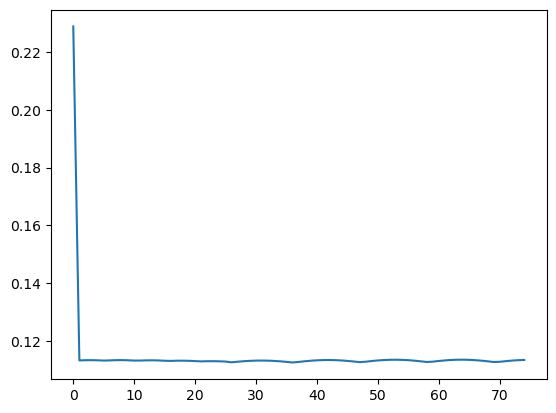

In [215]:
plt.plot(eigvec[:,0])

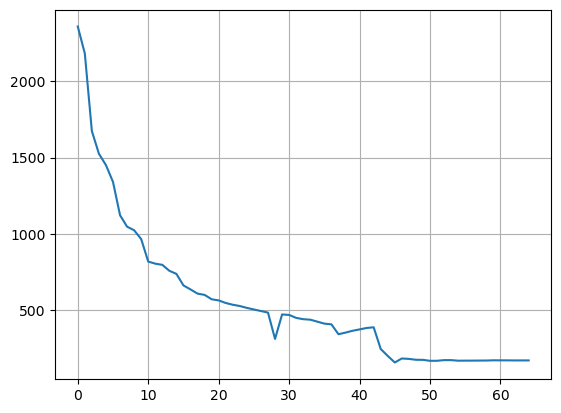

In [216]:
plt.plot(eigval[10:])
plt.grid()

In [ ]:
#aaa = np.random.random((100,100))
#aaa[23-2+1:23+2+2, 43-2:43+2+1]

In [ ]:
#aaa[23-2:23+2+1, 43-2:43+2+1]

In [ ]:
#aaa[23+1-5:23+1,43-5:(43+5+1)]

In [217]:
def lin_reg(train_dat):
    model = sm.OLS(train_dat[:,-1], train_dat[:,:-1])
    results = model.fit()
    betas = results.params
    
    y_pred = train_dat[:,1:-1]@betas[1:] + betas[0] 
    
    y_true = train_dat[:,-1]
    sigma2_hat = np.mean((y_true - y_pred)**2)

    return betas, sigma2_hat



In [218]:
parameters_estimate = lin_reg(neighborhood_data)

In [ ]:
#reg = LinearRegression(fit_intercept=False).fit(neighborhood_data[:,:-1], neighborhood_data[:,-1])

In [ ]:
#parameters_estimate =reg.coef_

In [ ]:
#parameters_estimate.shape

In [ ]:
#parameters_estimate[0][0]
#neighborhood_data[:,1]

In [228]:
parameters_estimate[0]

array([-1.31742178e-03,  1.53225418e-01,  1.85497732e-01,  1.78983753e-01,
        1.59210803e-01,  1.48350952e-01,  1.49765674e-01,  2.02666977e-01,
        1.87709030e-01,  1.67489357e-01,  1.34578454e-01,  7.35808107e-02,
        1.37147039e-01,  1.28949397e-01,  1.06329950e-01,  5.91933415e-02,
       -5.09231415e-04,  5.82540841e-02,  5.15875348e-02,  2.97521364e-02,
       -9.15555255e-03, -6.39323473e-02, -2.32113825e-03, -1.01559687e-02,
       -3.07262776e-02, -6.87464383e-02, -8.71362610e-04, -5.28348874e-03,
       -1.20477420e-02, -2.16685221e-02, -2.83811496e-02, -3.26962767e-02,
       -2.75767156e-02, -1.87432407e-02, -1.29370774e-02, -4.61777663e-03,
       -1.16625191e-03, -4.97625316e-04, -1.31500258e-02, -2.69796888e-02,
       -4.10096473e-02, -5.63852997e-02, -6.70851537e-02, -5.42316374e-02,
       -4.03793084e-02, -2.53148885e-02, -1.02327724e-02,  4.82438813e-05,
        8.53345439e-04, -1.29164583e-02, -3.65738274e-02, -6.18525287e-02,
       -8.67788261e-02, -

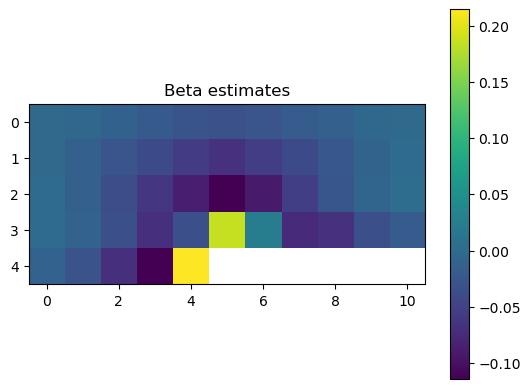

In [219]:
plt.imshow(np.concatenate((parameters_estimate[0][26:],np.array([np.inf,np.nan,np.nan,np.nan,np.nan,np.nan]))).reshape((5,11)))#,vmin=0)
plt.colorbar()
plt.title("Beta estimates")
#plt.savefig('../figures/GRF_beta_est.jpg')
plt.savefig('../figures_blur/GRF_beta_est_nbh_blur.jpg')

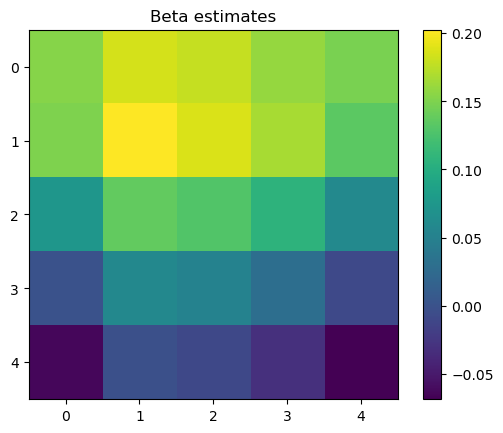

In [220]:
plt.imshow(parameters_estimate[0][1:26].reshape((5,5)))#,vmin=0)
plt.colorbar()
plt.title("Beta estimates")
plt.savefig('../figures_blur/GRF_beta_est_blur.jpg')


In [ ]:
np.sqrt(0.0010763107149353594)

In [242]:
def seq_sim(new_im, params, nbh_size, blur_size):
    betas, sigma2 = params
    #new_im = np.zeros(im_shape)
    #new_im = dataset[4]
    new_im_sample = new_im.copy()
    pred_im = new_im.copy()
    bl_im = new_im.copy()
    m, n = nbh_size
    h, w = blur_size
    h = h//2
    w = w//2
    for i in range(5, new_im.shape[0]-h):
        for j in range(n, new_im.shape[1]-n):
            #neighborhood = new_im[i-m:i,j-n:j+n+1]
            neighborhood = new_im_sample[(i+1-m):i+1,(j-n):(j+n+1)]
            blur_nbh = bl_im[i-h:i+h+1, j-w:j+w+1]
            flat_n = neighborhood.flatten()
            blur_nbh_flat = blur_nbh.flatten()[:]
            dlt = n

            #nbh_ij = flat_n[:-(dlt+1)]
            nbh_ij = flat_n[:-(dlt)]
            #mu_pred = np.dot(betas[:],nbh_ij)
            nbh_and_blur = np.concatenate((blur_nbh_flat,nbh_ij[:-1]))
            #mu_pred = nbh_ij[:-1]@betas[1:]+betas[0]
            mu_pred = nbh_and_blur@betas[1:]+betas[0]

            sample = np.random.normal(mu_pred, np.sqrt(sigma2))
            pred = mu_pred

            new_im_sample[i,j] = sample
            #pred_im[i,j] = pred

    return new_im_sample#pred_im #

In [222]:
seq_sim_sample = seq_sim(blurred_images_test[2],parameters_estimate, (5,5),blur_size=(5,5))

In [ ]:
seq_sim_sample2 = seq_sim(test_dataset[8],parameters_estimate, (5,5))

In [ ]:
seq_sim_sample3 = seq_sim(np.random.random((100,100)),parameters_estimate, (5,5))

In [ ]:
seq_sim_pred = seq_sim(test_dataset[7],parameters_estimate, (5,5))

In [ ]:
seq_sim_sample.shape

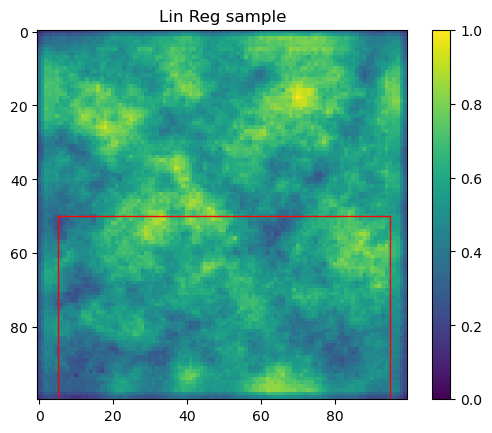

In [223]:
plt.imshow(seq_sim_sample, vmin=0,vmax=1)
x = [5, 95]
y = [50, 50]
xx = [5, 5]
yy = [50, 99]
xxx = [95, 95]
yyy = [50, 99]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.colorbar()
plt.title('Lin Reg sample')
#plt.savefig('../figures/GRF_sample_im1.jpg')
plt.show()

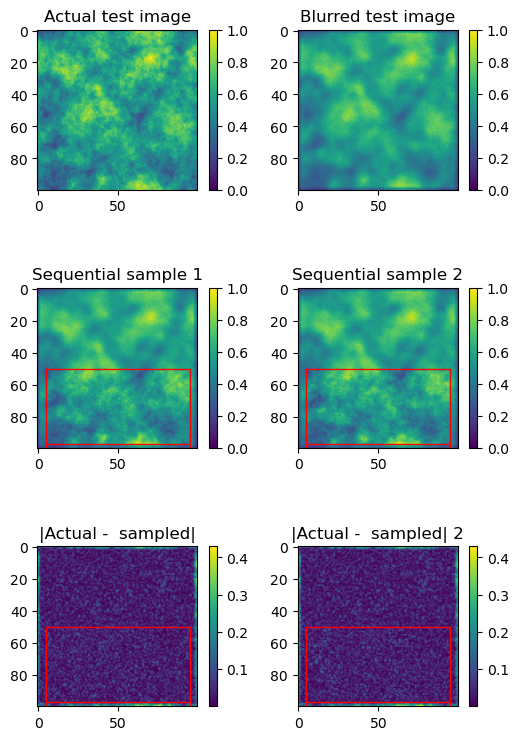

In [241]:
seq_sim_sample = seq_sim(blurred_images_test[2],parameters_estimate, (5,5),blur_size=(5,5))
seq_sim_sample_1 = seq_sim(blurred_images_test[2],parameters_estimate, (5,5),blur_size=(5,5))

fig, axes = plt.subplots(nrows=3, ncols=2)

im = axes.flat[0].imshow(test_dataset[2], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image")

im = axes.flat[1].imshow(blurred_images_test[2], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Blurred test image")

x = [5, 95]
y = [50, 50]
xx = [5, 5]
yy = [50, 99]
xxx = [95, 95]
yyy = [50, 99]
xxxx = [5, 95]
yyyy = [97, 97]

axes[1,0].plot(x, y, color="red", linewidth=1)
axes[1,0].plot(xx, yy, color="red", linewidth=1)
axes[1,0].plot(xxx, yyy, color="red", linewidth=1)
axes[1,0].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[2].imshow(seq_sim_sample, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("Sequential sample 1")

axes[1,1].plot(x, y, color="red", linewidth=1)
axes[1,1].plot(xx, yy, color="red", linewidth=1)
axes[1,1].plot(xxx, yyy, color="red", linewidth=1)
axes[1,1].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[3].imshow(seq_sim_sample_1, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("Sequential sample 2")

axes[2,0].plot(x, y, color="red", linewidth=1)
axes[2,0].plot(xx, yy, color="red", linewidth=1)
axes[2,0].plot(xxx, yyy, color="red", linewidth=1)
axes[2,0].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[4].imshow(np.abs(test_dataset[2]-seq_sim_sample))#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[2,0],fraction=0.046, pad=0.04)
axes[2,0].set_title("|Actual -  sampled|")

axes[2,1].plot(x, y, color="red", linewidth=1)
axes[2,1].plot(xx, yy, color="red", linewidth=1)
axes[2,1].plot(xxx, yyy, color="red", linewidth=1)
axes[2,1].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[5].imshow(np.abs(test_dataset[2]-seq_sim_sample_1))#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[2,1],fraction=0.046, pad=0.04)
axes[2,1].set_title("|Actual -  sampled| 2")


fig.tight_layout()
fig.set_figheight(8)
fig.set_figwidth(6)
plt.savefig('../figures_blur/GRF_sample_blur_1.jpg')
plt.show()

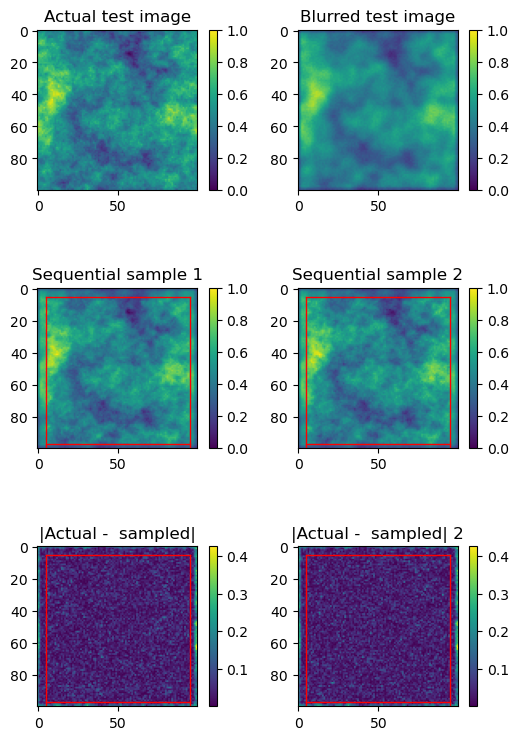

In [243]:
seq_sim_sample = seq_sim(blurred_images_test[8],parameters_estimate, (5,5),blur_size=(5,5))
seq_sim_sample_1 = seq_sim(blurred_images_test[8],parameters_estimate, (5,5),blur_size=(5,5))

fig, axes = plt.subplots(nrows=3, ncols=2)

im = axes.flat[0].imshow(test_dataset[8], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image")

im = axes.flat[1].imshow(blurred_images_test[8], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Blurred test image")

x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [95, 95]
yyy = [5, 99]
xxxx = [5, 95]
yyyy = [97, 97]

axes[1,0].plot(x, y, color="red", linewidth=1)
axes[1,0].plot(xx, yy, color="red", linewidth=1)
axes[1,0].plot(xxx, yyy, color="red", linewidth=1)
axes[1,0].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[2].imshow(seq_sim_sample, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("Sequential sample 1")

axes[1,1].plot(x, y, color="red", linewidth=1)
axes[1,1].plot(xx, yy, color="red", linewidth=1)
axes[1,1].plot(xxx, yyy, color="red", linewidth=1)
axes[1,1].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[3].imshow(seq_sim_sample_1, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,1],fraction=0.046, pad=0.04)
axes[1,1].set_title("Sequential sample 2")

axes[2,0].plot(x, y, color="red", linewidth=1)
axes[2,0].plot(xx, yy, color="red", linewidth=1)
axes[2,0].plot(xxx, yyy, color="red", linewidth=1)
axes[2,0].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[4].imshow(np.abs(test_dataset[8]-seq_sim_sample))#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[2,0],fraction=0.046, pad=0.04)
axes[2,0].set_title("|Actual -  sampled|")

axes[2,1].plot(x, y, color="red", linewidth=1)
axes[2,1].plot(xx, yy, color="red", linewidth=1)
axes[2,1].plot(xxx, yyy, color="red", linewidth=1)
axes[2,1].plot(xxxx, yyyy, color="red", linewidth=1)
im = axes.flat[5].imshow(np.abs(test_dataset[8]-seq_sim_sample_1))#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[2,1],fraction=0.046, pad=0.04)
axes[2,1].set_title("|Actual -  sampled| 2")

fig.tight_layout()

fig.set_figheight(8)
fig.set_figwidth(6)
plt.savefig('../figures_blur/GRF_sample_blur_2.jpg')
plt.show()

In [170]:
#plt.imshow(np.abs(test_dataset[8]-seq_sim_sample))#,vmin=0,vmax=1)
#plt.colorbar()

In [ ]:
plt.imshow(seq_sim_sample, vmin=0,vmax=1)
x = [5, 95]
y = [50, 50]
xx = [5, 5]
yy = [50, 99]
xxx = [95, 95]
yyy = [50, 99]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.colorbar()
plt.title('Lin Reg sample')
plt.savefig('../figures/GRF_sample_im1.jpg')
plt.show()

In [ ]:
plt.imshow(seq_sim_sample2, vmin=0,vmax=1)
x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [95, 95]
yyy = [5, 99]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.colorbar()
plt.title('Lin Reg sample 2')
plt.savefig('../figures/GRF_sample_im2.jpg')
plt.show()

In [ ]:
plt.imshow(seq_sim_sample3, vmin=0,vmax=1)
x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [94, 94]
yyy = [5, 99]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.colorbar()
plt.title('Lin Reg sample random init')
plt.savefig('../figures/GRF_sample_im3.jpg')
plt.show()

In [ ]:
plt.imshow(seq_sim_pred, vmin=0,vmax=1)
x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [95, 95]
yyy = [5, 99]
plt.plot(x, y, color="red", linewidth=1)
plt.plot(xx, yy, color="red", linewidth=1)
plt.plot(xxx, yyy, color="red", linewidth=1)
plt.colorbar()
plt.savefig('../figures/GRF_pred_im1.jpg')
plt.show()

In [ ]:
plt.imshow(test_dataset[7]-seq_sim_pred, vmin=0,vmax=1)

In [ ]:
from scipy.stats import norm

In [ ]:
x = np.arange(-0.2, 0.2, 0.0001)
plt.hist((test_dataset[7][5:,5:95]-seq_sim_pred[5:,5:95]).flatten(), bins=30, density=True,label="Residual")
plt.plot(x, norm.pdf(x, 0, np.sqrt(parameters_estimate[1])), label= 'N(0,sigma^2)')
plt.xlabel('Residual')
plt.ylabel('Probability')
plt.legend()
plt.show()

In [ ]:
parameters_estimate[1]


In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)#,sharex=True, sharey=True)

im = axes.flat[0].imshow(test_dataset[7], vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,0],fraction=0.046, pad=0.04)
axes[0,0].set_title("Actual test image")

x = [5, 95]
y = [5, 5]
xx = [5, 5]
yy = [5, 99]
xxx = [95, 95]
yyy = [5, 99]
axes[0,1].plot(x, y, color="red", linewidth=1)
axes[0,1].plot(xx, yy, color="red", linewidth=1)
axes[0,1].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[1].imshow(seq_sim_pred, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[0,1],fraction=0.046, pad=0.04)
axes[0,1].set_title("Predicted values")


axes[1,0].plot(x, y, color="red", linewidth=1)
axes[1,0].plot(xx, yy, color="red", linewidth=1)
axes[1,0].plot(xxx, yyy, color="red", linewidth=1)
im = axes.flat[2].imshow(np.abs(test_dataset[7]-seq_sim_pred))#, vmin=0, vmax=1)
plt.colorbar(im, ax=axes[1,0],fraction=0.046, pad=0.04)
axes[1,0].set_title("|Actual - predicted|")
#axes.cax.colorbar(im)
#axes.cax.toggle_label(True)
#fig.colorbar(im)
#fig.tight_layout()
x = np.arange(-0.2, 0.2, 0.0001)
axes[1,1].hist((test_dataset[7][5:,5:95]-seq_sim_pred[5:,5:95]).flatten(), bins=30, density=True,label="Residual")
axes[1,1].plot(x, norm.pdf(x, 0, np.sqrt(parameters_estimate[1])), label= 'N(0,sigma^2)')
axes[1,1].set_xlabel('Residual')
axes[1,1].set_ylabel('Probability')
axes[1,1].legend(loc='upper right',fontsize='x-small')
#fig.set_figheight(5)
#fig.set_figwidth(14)
fig.tight_layout()
plt.savefig('../figures/GRF_pred_and_actual.jpg')
plt.show()

In [ ]:
#plot train im

#for i in range(1, 5):
#    plt.subplot(2, 2, i)
#    plt.imshow(dataset[i])
#plt.colorbar()
#plt.show()

In [ ]:
#plot train im

fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    #print(i,ax)
    im = ax.imshow(dataset[i+1], vmin=0, vmax=1)

image = fig.colorbar(im, ax=axes.ravel().tolist())
fig.suptitle('Example train images')
plt.savefig('../figures/GRF_train_im.jpg')#, image)
plt.show()

In [ ]:
image